In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

### 기본 설정

In [2]:
source_path = './data/cat_128.png' #원본 이미지 주소
n = 8 #해상도를 n배 키움
source_image = cv2.imread(source_path)
dest_size = (source_image.shape[0]*8, source_image.shape[1]*8) #새로운 이미지 크기
print(f"{source_image.shape[:2]} -> {dest_size}")

(128, 128) -> (1024, 1024)


## 원본 이미지

In [3]:
def image_show(image, width=10, height=10):
    # Create a larger figure
    plt.figure(figsize=(width, height))
    
    # Convert the image from BGR to RGB for correct color display
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()

In [4]:
def image_show(image, width=10, height=10):
    # Ensure the image is in a compatible format for cv2.cvtColor (CV_8U or CV_32F)
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)  # Convert to uint8 by clipping and casting
    
    # Create a larger figure
    plt.figure(figsize=(width, height))
    
    # Convert the image from BGR to RGB for correct color display
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()

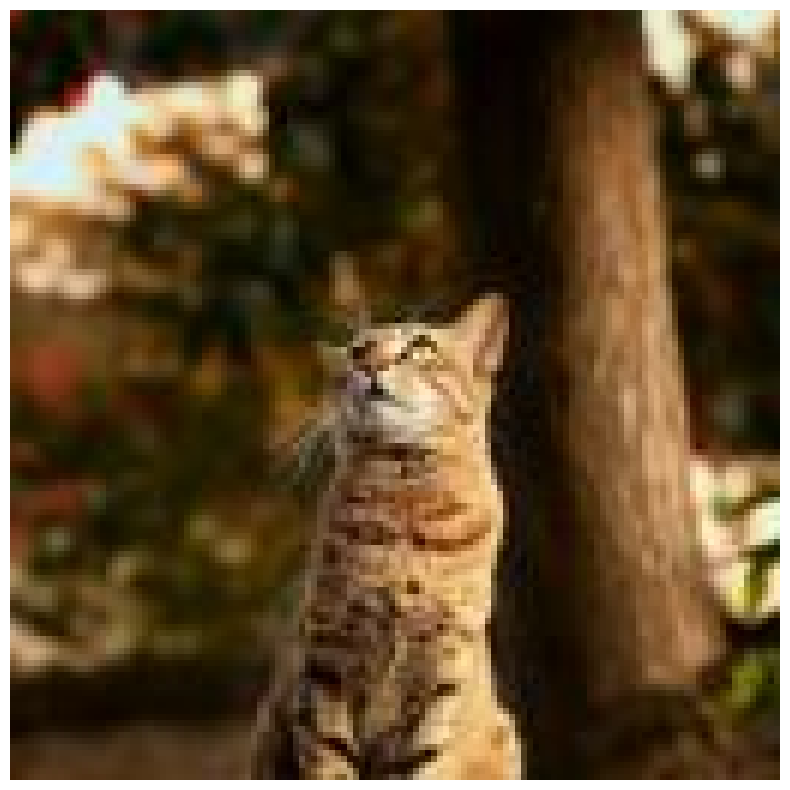

In [5]:
image_show(source_image)

### 제가 짠 upsampling코드  
- bilinear interpolation을 이용했습니다.
- 공간적으로 multi threading에 되어있지 않아서 매우 느리게 작동합니다.

In [6]:
def upsample_bilinear(source_image, dest_size):
    # ----------------------------------------------------------------------------------------------------------
    # Implement the upsaming algorithm with bilienar interpolation
    # Args:
    #     source_image (numpy array): (old_h, old_w, 3)
    #     dest_size (tuple): (2,) 
    #     -- dest_size[0]: new_h 
    #     -- dest_size[1]: new_w
    # Return:
    #     dest_image (numpy.ndarray): (new_h, new_w, 3)
    # ----------------------------------------------------------------------------------------------------------
    
    src_h, src_w = source_image.shape[:2] #기존 이미지 크기
    dest_h, dest_w = dest_size #새로운 이미지 크기
    
    # ----------------------------------------------------------------------------------------------------------
    # dest좌표에따라 대응되는 source 이미지에서의 좌표를 계산 하기위한 두개의 일차함수를 만든다.
    # slope_w * dest_w + intercept_w = src_w
    # slope_h * dest_w + intercept_h = src_h
    # 형태로 계산 할 것이다.
    # 기울기와 절편은 
    # (-0.5, -0.5) -> (-0.5, -0.5), (dest_w-0.5, dest_h-0.5) -> (src_w-0.5, src-0.5) 임을 이용하여 찾는다.
    # ----------------------------------------------------------------------------------------------------------
    
    slope_h = src_h/dest_h
    intercept_h = (slope_h - 1)/2
    
    slope_w = src_w/dest_w
    intercept_w = (slope_w - 1)/2
    
    dest_image = np.zeros((dest_h, dest_w, 3)) #변환된 이미지 생성

    source_image = np.pad(source_image, pad_width=((1, 1), (1, 1), (0, 0)), mode='edge') #source_image를 1칸 padding해줌(replication padding)
    
    # ----------------------------------------------------------------------------------------------------------
    # 1. dest_image각 픽셀을 돌며 dest_image에 대응되는 source_image의 좌표를 계산한다.
    # 2. 해당 좌표에 맞는 픽셀값을 bilinear interpolation을 이용하여 계산한다.
    # ----------------------------------------------------------------------------------------------------------
    for y_dest in range(dest_h):
        for x_dest in range(dest_w):
            # 1.대응되는 source_image의 좌표를 계산
            x_src = slope_w * x_dest + intercept_w
            y_src = slope_h * y_dest + intercept_h
            
            # 2.bilinear interpolation
            x0, y0 = int(x_src), int(y_src)
            x1, y1 = x0 + 1, y0 + 1
            
            # 가중치 계산을 위한 길이
            wx = x_src - x0
            wy = y_src - y0
            
            # 네 개의 이웃 픽셀 값 가져오기
            v1 = source_image[y0, x0]
            v2 = source_image[y0, x1]
            v3 = source_image[y1, x0]
            v4 = source_image[y1, x1]

            dest_image[y_dest, x_dest] = (1 - wx) * (1 - wy) * v1 + wx * (1 - wy) * v2 + (1 - wx) * wy * v3 + wx * wy * v4
    
    return dest_image

Execution time: 8.618899 seconds
Source image


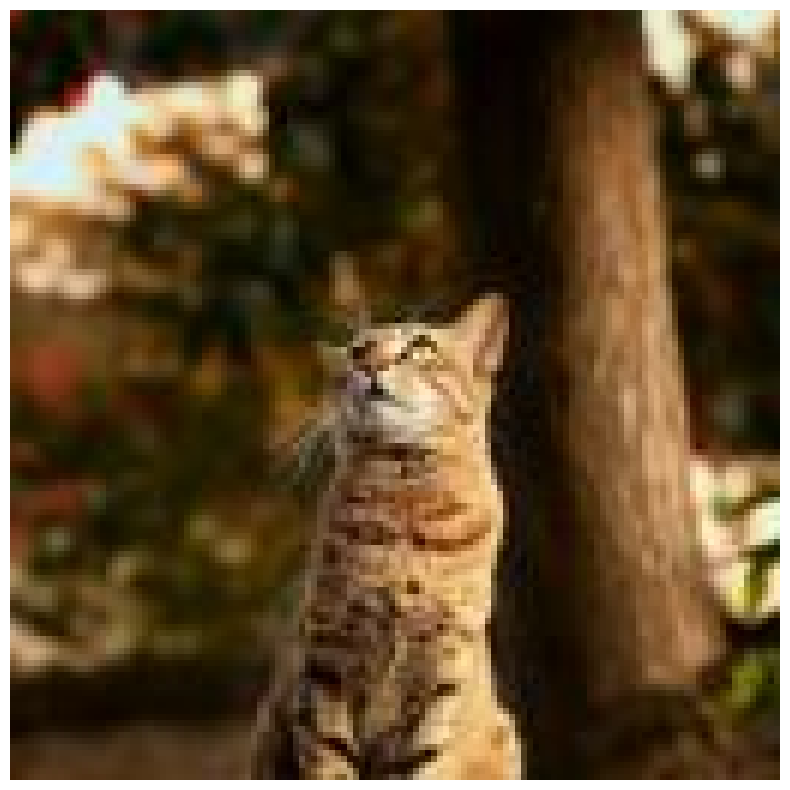

Bilinear


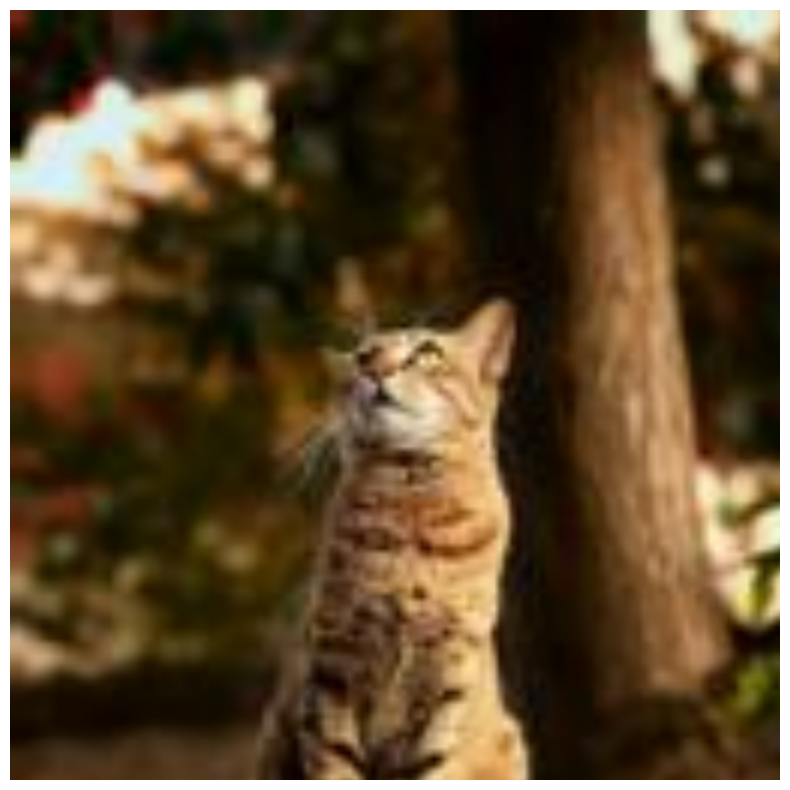

In [7]:
start_time = time.time()
dest_image = upsample_bilinear(source_image, dest_size)
end_time = time.time()

print(f"Execution time: {(end_time - start_time):.6f} seconds")
print("Source image")
image_show(source_image)
print("Bilinear")
image_show(dest_image)

## OpenCV에서 제공하는 함수를 이용할때  
- 내부적으로 공간단위의 multi threading을 하도록 되어있어서 훨씬 빠르게 작동합니다.  
- bilinear말고도 더 정교한 interpolation 방법을 제공합니다.(Cubic Interpolation, LANCZOS4 Interpolation)

source image


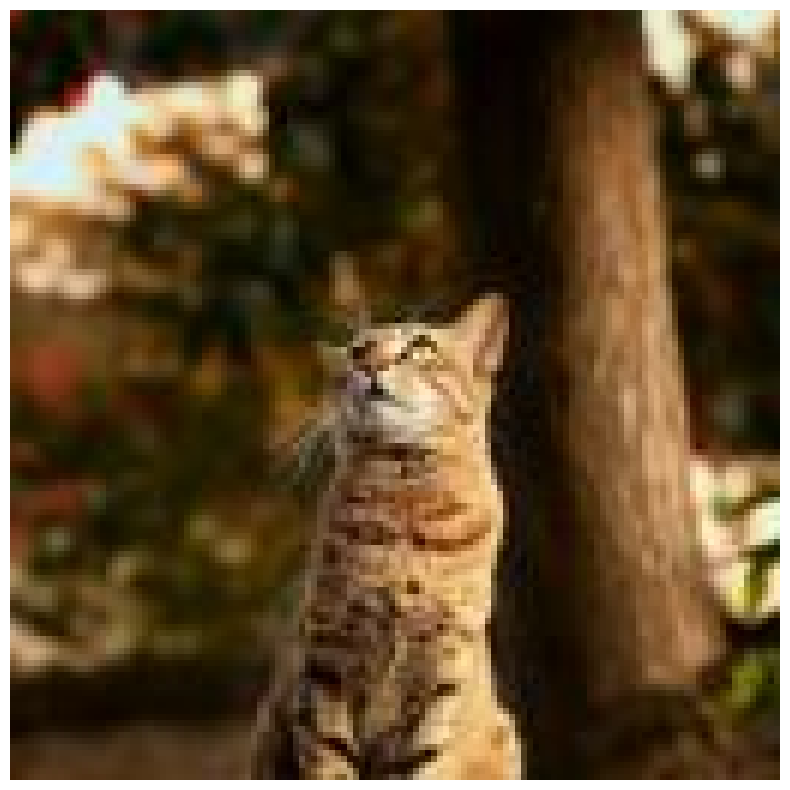

Bilinear
Execution time: 0.003163 seconds


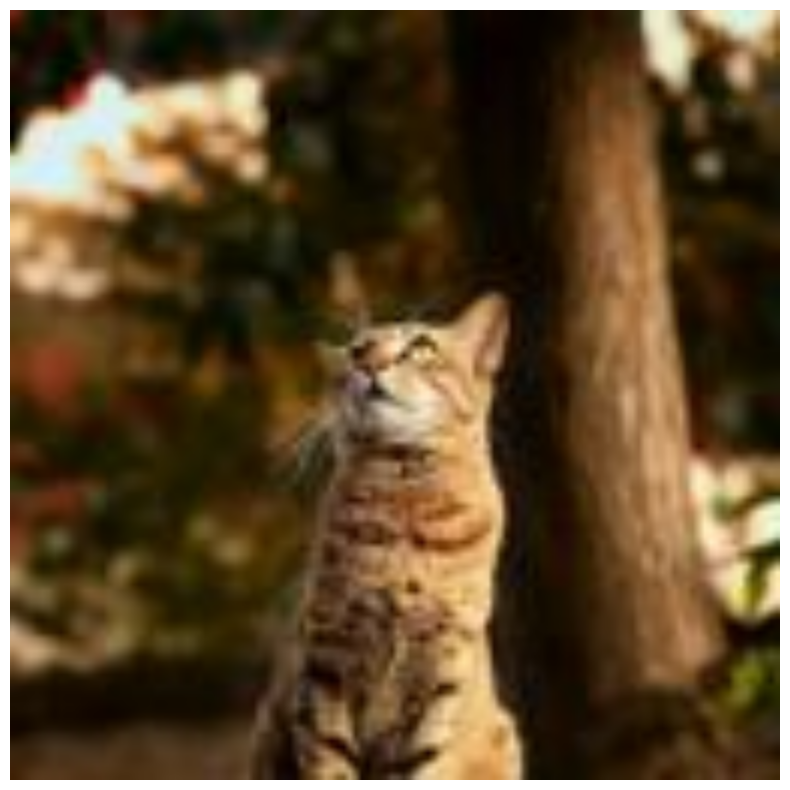

Cubic
Execution time: 0.002012 seconds


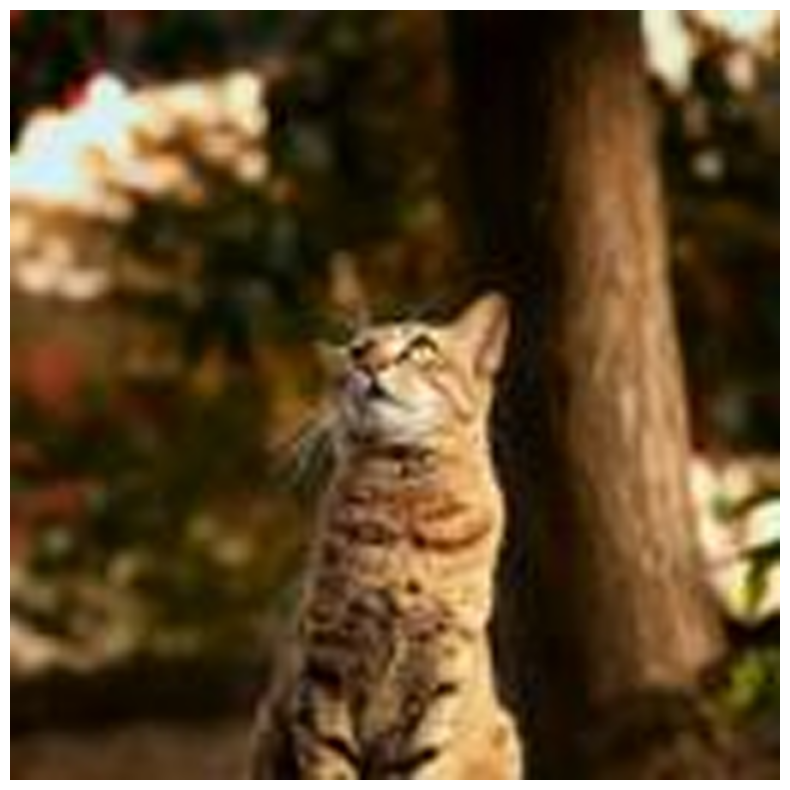

LANCZOS4
Execution time: 0.004005 seconds


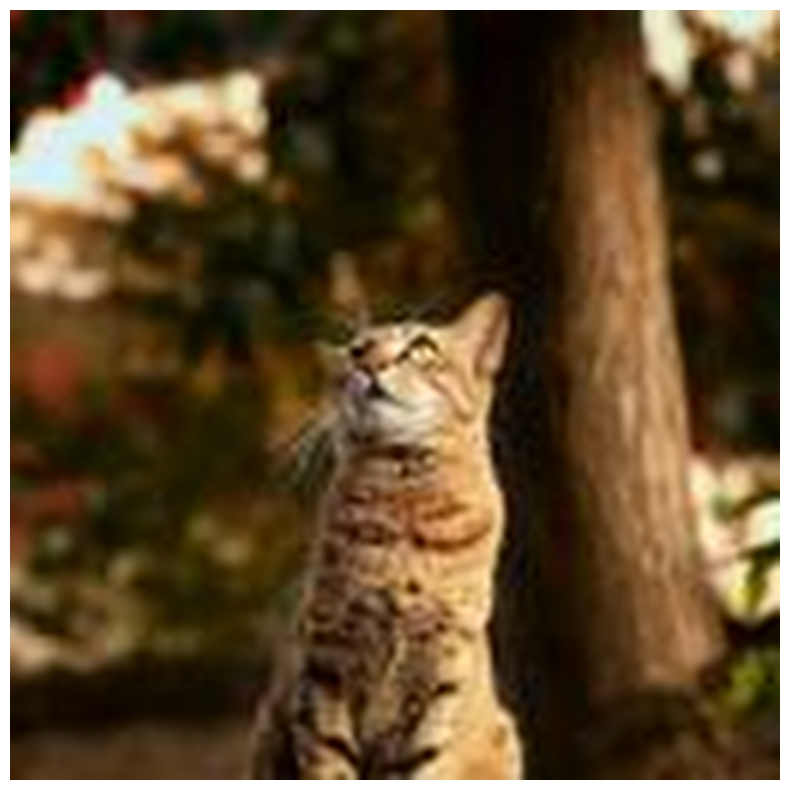

In [8]:
print("source image")
image_show(source_image)

start_time = time.time()
dest_image = cv2.resize(source_image, dest_size, interpolation=cv2.INTER_LINEAR)
end_time = time.time()

print("Bilinear")
print(f"Execution time: {(end_time - start_time):.6f} seconds")
image_show(dest_image)

start_time = time.time()
dest_image = cv2.resize(source_image, dest_size, interpolation=cv2.INTER_CUBIC)
end_time = time.time()

print("Cubic")
print(f"Execution time: {(end_time - start_time):.6f} seconds")
image_show(dest_image)

start_time = time.time()
dest_image = cv2.resize(source_image, dest_size, interpolation=cv2.INTER_LANCZOS4)
end_time = time.time()

print("LANCZOS4")
print(f"Execution time: {(end_time - start_time):.6f} seconds")
image_show(dest_image)

# 동영상 처리에 적용

In [9]:
input_video_path = 'data/코끼리_480_270.mp4'  # 입력 비디오 경로
output_video_path = 'data/코끼리_enhanced.mp4'  # 출력 비디오 경로

input_video_path 비디오를 읽어와서 각 프레임에 transform_frame_fn함수를 수행 한 후 output_video_path에 저장한다.

In [10]:
def process_video(input_video_path, output_video_path, transform_frame_fn):
    """
    입력 비디오의 각 프레임에 대해 제공된 transform_frame_fn을 적용한 후 새로운 비디오를 생성합니다.
    
    :param input_video_path: 입력 비디오 파일 경로
    :param output_video_path: 출력 비디오 파일 경로
    :param transform_frame_fn: 프레임을 처리할 함수 (화질 개선 함수 등)
    """
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(input_video_path)
    
    #원본의 fps유지
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # 비디오 출력 객체를 위한 설정
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # 출력 비디오 코덱 (예: XVID)
    
    # 비디오 캡처에서 첫 번째 프레임을 읽어 새 크기 결정 (화질 개선 함수로 크기가 변경될 수 있음)
    ret, first_frame = cap.read()
    if not ret:
        print("비디오 읽기 실패")
        return
    
    # 첫 번째 프레임을 처리하고 그에 맞는 출력 비디오 크기를 설정
    enhanced_first_frame = transform_frame_fn(first_frame)
    new_width, new_height = enhanced_first_frame.shape[1], enhanced_first_frame.shape[0]
    
    # 비디오 출력 객체 생성 (변경된 크기 사용)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (new_width, new_height))
    
    # 비디오 프레임 처리
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 첫 번째 프레임으로 다시 이동
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # 각 프레임에 화질 개선 함수 적용
        enhanced_frame = transform_frame_fn(frame)
        
        # 개선된 프레임을 출력 비디오에 추가
        out.write(enhanced_frame)
        
    # 리소스 해제
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"비디오 처리 완료: {output_video_path}")
 

frame에 수행할 동작을 정의하는 함수

In [11]:
#이미지의 크기를 바꾼다.
def resize_frame(frame, scale_factor=4):
    height, width = frame.shape[:2]
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    # 프레임 크기 조정 (리사이징)
    resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
    return resized_frame

In [15]:
def enhance_frame_quality(frame, scale_factor=4):
    resized = resize_frame(frame, scale_factor)
    
    # 선명도 개선
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(resized, -1, kernel)
    
    # 노이즈 제거
    denoised = cv2.fastNlMeansDenoisingColored(sharpened, None, 10, 10, 7, 21)
    
    # 대비 향상
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl,a,b))
    enhanced_frame = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    return enhanced_frame

In [16]:
start_time = time.time()
process_video(input_video_path, output_video_path, enhance_frame_quality)
end_time = time.time()

print(f"Execution time: {(end_time - start_time):.6f} seconds")

비디오 처리 완료: data/코끼리_enhanced.mp4
Execution time: 947.494874 seconds


시간적 병렬처리 코드

In [17]:
def proces_video(input_video_path, output_video_path, num_workers = 8):
    return